In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
import torch.optim as optim
from cebra_utils import *
import pickle

In [2]:

data_directory = '/mnt/teams/Tsuchitori/IV2_reaching_30hz_30frame_DFF/'
neural_data_paths = [ data_directory + 'brain/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

behavior_data_paths = [  data_directory + 'camera1/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

dino_paths = [ data_directory + 'dino/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

label_paths = list(filter(lambda x : x.endswith('.pickle') , iter(os.listdir('.'))))

neural_data_paths.sort()
behavior_data_paths.sort()
dino_paths.sort()
label_paths.sort()

In [3]:
from sklearn.metrics import confusion_matrix
# confusion = confusion_matrix(true_labels, predicted_labels)
# plot the confusion matrix


def plot_confusion_matrix(confusion_matrix, labels, title, ax=None):
    # Normalize the confusion matrix
    normalized_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    if ax is None:
        fig, ax = plt.subplots()
    im = ax.imshow(normalized_matrix, cmap='cividis', vmin=0, vmax=1)

    # Set colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Normalized', rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, f'{confusion_matrix[i, j]}', ha="center", va="center", color="w")

    # Set labels for the x-axis, y-axis, and title
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)

    # add accuracy to title
    ax.set_title(title + f'\nAccuracy: {accuracy:.2f}')



In [4]:
#model_group = torch.load('models/single_session/cebra_model_list.pt').eval().to('cuda')
model_path = 'models/Water_reaching_single_session/cebra_model_flattened_offset1-'

In [5]:
name_to_model_id = { 
    '2020_11_2_MV1_run' : 0,
    '2020_11_9_MV1_run' : 1,
    '2021_1_12_MV1_run' : 2,
    '2020_12_10_MV1_run' : 3,
    '2021_1_8_MV1_run' : 4,
    '2020_11_17_MV1_run' : 5,
    '2020_11_23_MV1_run' : 6,
    '2020_12_4_MV1_run' : 7,
}

KeyboardInterrupt: 

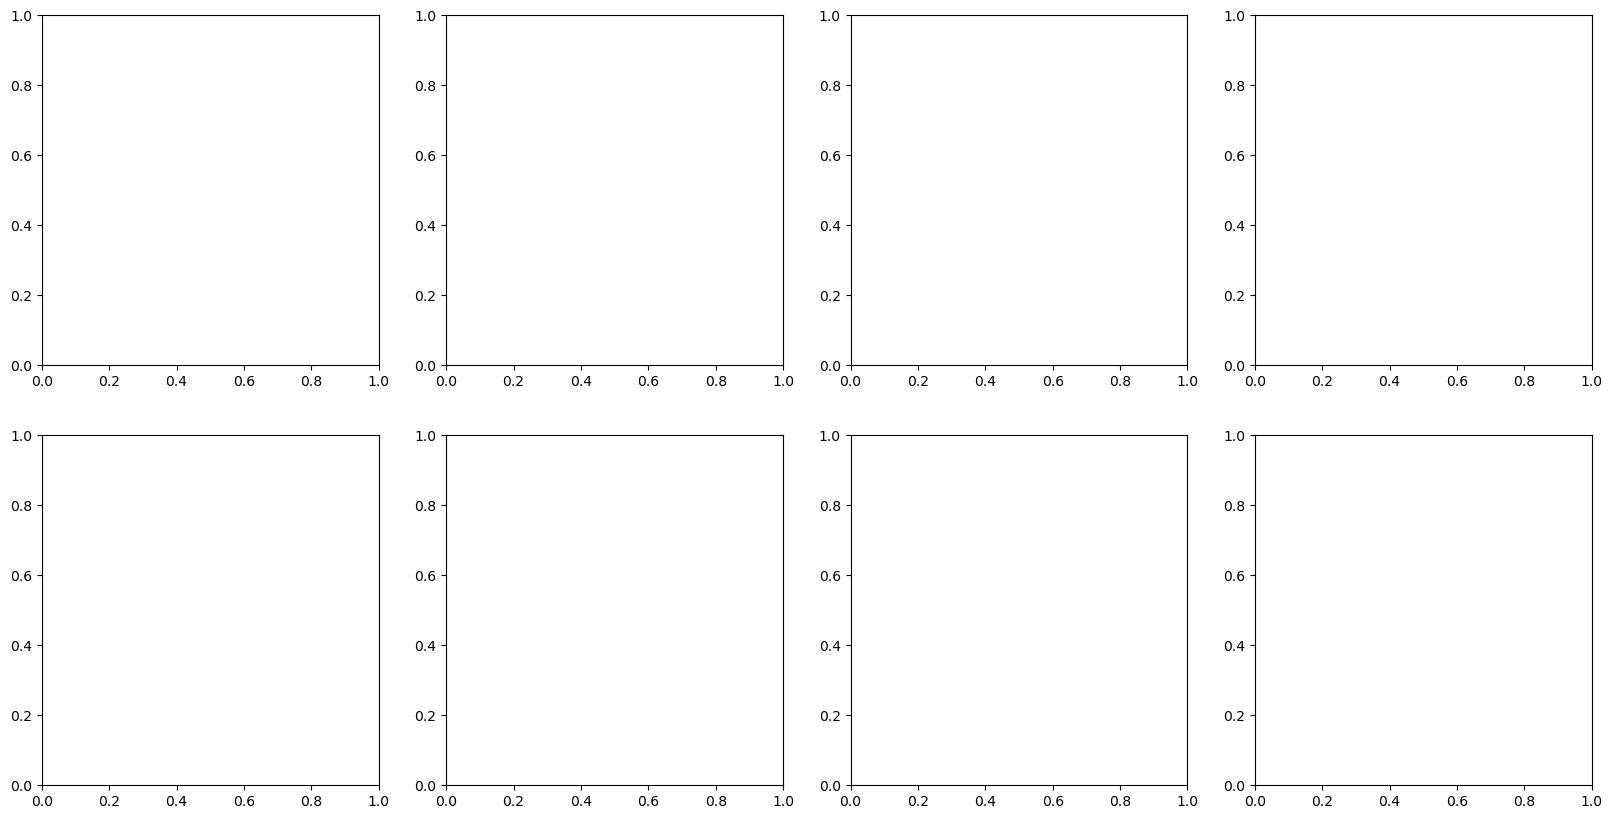

In [6]:
from sklearn.neighbors import NearestNeighbors

con_mat = []
# create 8 subplots for each session
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for index in range(len(neural_data_paths)):
    embeddings = []
    name = []
    valid_embeddings = []
    valid_name = []
    labels = []
    valid_labels = []
    dataset_name  = neural_data_paths[index].split("/")[-1].split(".")[0]
    temp_data, temp_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.0, max = 0.8)
    temp_valid_data, temp_valid_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.8, max = 1)
    model = torch.load(model_path + dataset_name + '.pt').model.eval().to('cuda')
    # data.extend(temp_data)
    # valid_data.extend(temp_valid_data)
    print('Generating embeddings')
    temp_embeddings = flatten_data([model(torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_data)])
    temp_valid_embeddings = flatten_data([model(torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_valid_data)])
    embeddings.extend(temp_embeddings)
    valid_embeddings.extend(temp_valid_embeddings)
    name.extend(temp_name)
    valid_name.extend(temp_valid_name)
    for label, data in zip(temp_name, temp_data):
        if label.split('_')[0] == 'move':
            labels.extend(np.tile(np.array([0, 1]),[len(data), 1]))
        else:
            labels.extend(np.tile(np.array([1, 0]),[len(data), 1]))
    for label, data in zip(temp_valid_name, temp_valid_data):
        if label.split('_')[0] == 'move':
            valid_labels.extend(np.tile(np.array([0, 1]),[len(data), 1]))
        else:
            valid_labels.extend(np.tile(np.array([1, 0]),[len(data), 1]))

    labels = np.array(labels)
    valid_labels = np.array(valid_labels)
    decoder = cebra.KNNDecoder(n_neighbors=2, metric='cosine')
    print('Fitting decoder')
    decoder.fit(embeddings, labels)
    pred_labels = decoder.predict(valid_embeddings)
    clip_valid_labels = reshape_frames(np.argmax(valid_labels, axis=1), temp_valid_data)
    clip_pred_labels = reshape_frames(np.argmax(pred_labels, axis=1), temp_valid_data)
    clip_valid_labels = [np.argmax(np.bincount(x)) for x in (clip_valid_labels)]
    clip_pred_labels = [np.argmax(np.multiply(np.bincount(x), [1, 1])) for x in (clip_pred_labels)]

    confusion = confusion_matrix(clip_valid_labels, clip_pred_labels)
    print(confusion)
    plot_confusion_matrix(confusion, ['nomove', 'move'], f'Confusion matrix for {neural_data_paths[index].split("/")[-1].split(".")[0]}', ax=ax[index//4, index%4])
    con_mat.append(confusion)
plt.show()

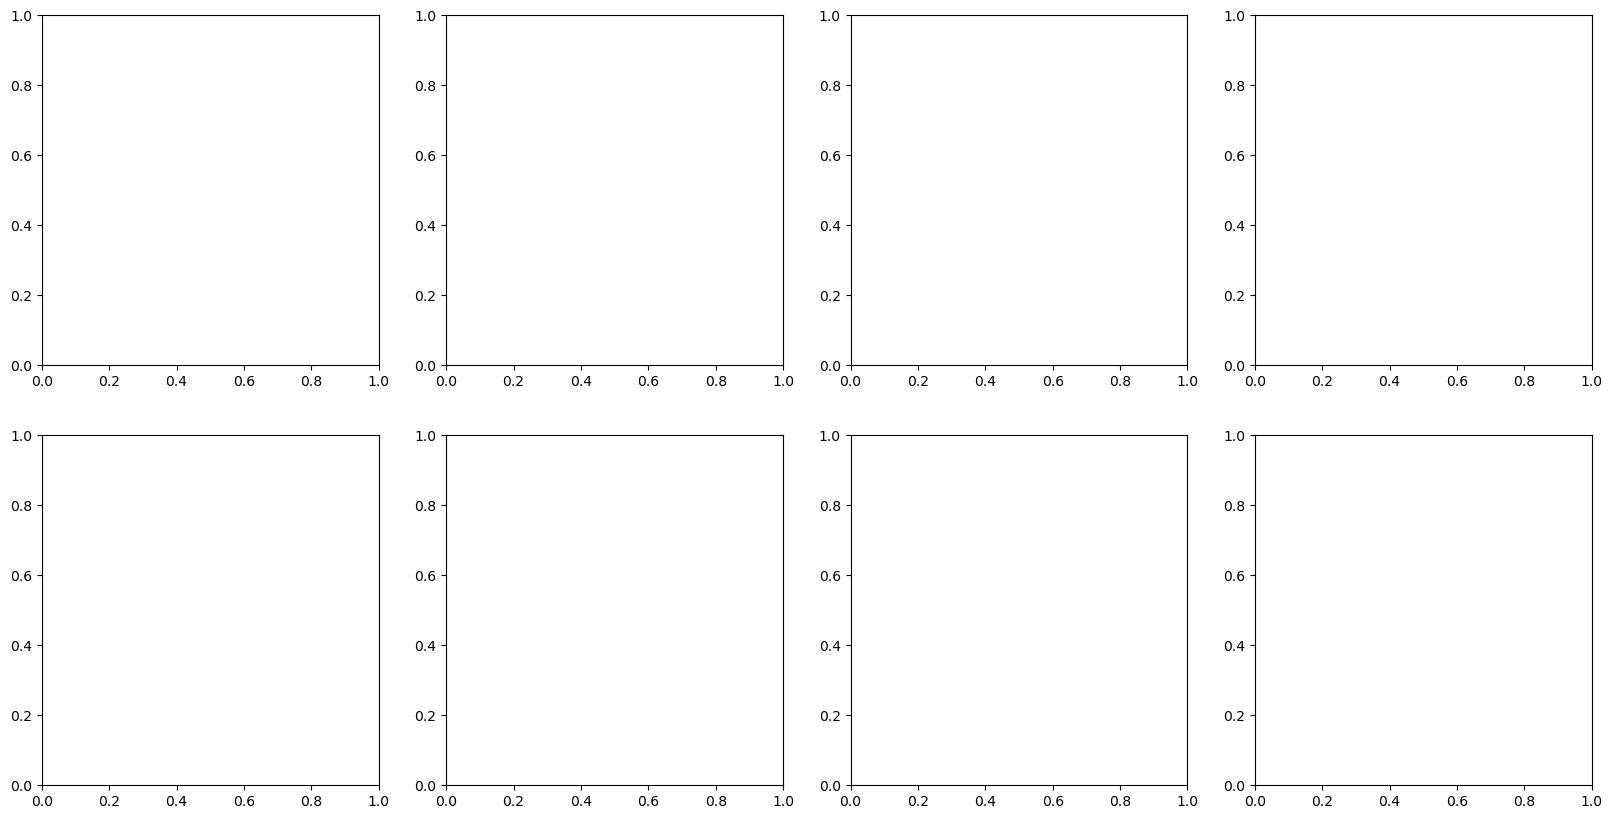

In [ ]:
from sklearn.neighbors import NearestNeighbors

con_mat = []
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for index in range(len(neural_data_paths)):
    embeddings = []
    name = []
    valid_embeddings = []
    valid_name = []
    labels = []
    valid_labels = []


    dataset_name  = neural_data_paths[index].split("/")[-1].split(".")[0]
    temp_data, temp_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.0, max = 0.8)
    temp_valid_data, temp_valid_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.8, max = 1)

    model = torch.load(model_path + dataset_name + '.pt').model.eval().to('cuda')

    # data.extend(temp_data)
    # valid_data.extend(temp_valid_data)
    print('Generating embeddings')
    temp_embeddings = flatten_data([model(torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_data)])
    temp_valid_embeddings = flatten_data([model(torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_valid_data)])
    embeddings.extend(temp_embeddings)
    valid_embeddings.extend(temp_valid_embeddings)
    name.extend(temp_name)
    valid_name.extend(temp_valid_name)
    for label, data in zip(temp_name, temp_data):
        if label.split('_')[0] == 'move':
            labels.extend(np.tile(np.array([0, 1]),[len(data), 1]))
        else:
            labels.extend(np.tile(np.array([1, 0]),[len(data), 1]))
    for label, data in zip(temp_valid_name, temp_valid_data):
        if label.split('_')[0] == 'move':
            valid_labels.extend(np.tile(np.array([0, 1]),[len(data), 1]))
        else:
            valid_labels.extend(np.tile(np.array([1, 0]),[len(data), 1]))

    labels = np.array(labels)
    valid_labels = np.array(valid_labels)
    decoder = cebra.KNNDecoder(n_neighbors=6, metric='cosine')
    print('Fitting decoder')
    decoder.fit(embeddings, labels)
    pred_labels = decoder.predict(valid_embeddings)
    print(pred_labels)
    confusion = confusion_matrix(np.argmax(valid_labels, axis=1), np.argmax(pred_labels, axis=1))
    plot_confusion_matrix(confusion, ['nomove', 'move'], f'Confusion matrix for {neural_data_paths[index].split("/")[-1].split(".")[0]}', ax=ax[index//4, index%4])
    con_mat.append(confusion)
plt.show()


Generating embeddings
Fitting decoder
[5, 4, 5, 5, 5, 3, 3, 2, 5, 5, 6, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 6, 5, 5, 5, 4, 4, 6, 5, 4, 6, 4, 5, 5, 6, 5, 5, 6, 6, 5, 5, 4, 6, 6, 2, 6, 5, 4, 5, 6, 5, 5, 6, 6, 3, 5, 5, 5, 5, 5, 2, 6, 5, 6, 5, 3, 5, 4, 5]
Generating embeddings
Fitting decoder
[5, 6, 0, 5, 5, 5, 5, 5, 5, 6, 4, 5, 4, 4, 4, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 4, 5, 5, 5, 5, 6, 4, 5, 5, 5, 4, 6, 5, 3, 4, 5, 5, 5, 5, 2, 5, 4, 5, 5, 5, 5, 2, 5]
Generating embeddings
Fitting decoder
[5, 5, 5, 6, 5, 6, 6, 6, 6, 5, 5, 5, 5, 5, 6, 5, 6, 6, 6, 5, 6, 5, 5, 6, 5, 5, 6, 5, 6, 5, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 6, 6, 5, 6, 5, 6, 5, 5, 5, 5, 6]
Generating embeddings
Fitting decoder
[2, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 2, 2, 5, 4, 5, 5, 6, 6, 5, 5, 3, 5]
Generating embeddings
Fitting decoder
[3, 5, 4, 4, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 4, 5, 5, 4, 6, 0, 0, 5, 4, 5, 5, 5, 5, 5, 5]
Generating embeddings
Fitting decoder
[3, 5, 0, 5, 5, 3, 5, 5, 5, 4, 5, 4, 4, 5, 5, 5, 4

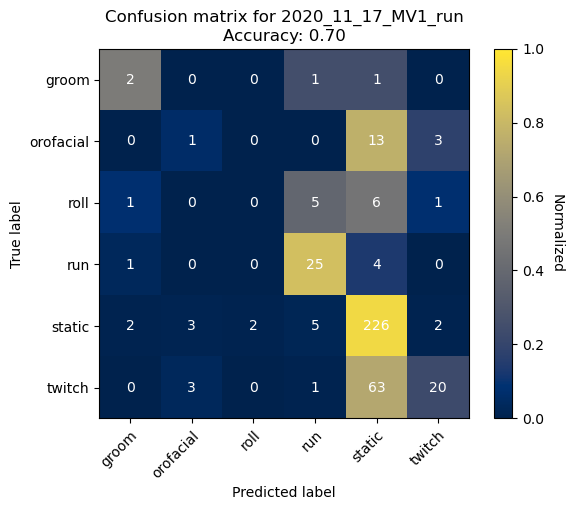

In [ ]:
from sklearn.neighbors import NearestNeighbors

pred_labels_total = []
valid_labels_total = []

for index in range(len(neural_data_paths)):
    embeddings = []
    name = []
    valid_embeddings = []
    valid_name = []
    labels = []
    valid_labels = []
    dataset_name  = neural_data_paths[index].split("/")[-1].split(".")[0]
    temp_data, temp_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.0, max = 0.15)
    temp_valid_data, temp_valid_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.15, max = 0.2)
    # data.extend(temp_data)
    # valid_data.extend(temp_valid_data)
    print('Generating embeddings')
    temp_embeddings = flatten_data([model_group[name_to_model_id[dataset_name]](torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_data)])
    temp_valid_embeddings = flatten_data([model_group[name_to_model_id[dataset_name]](torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_valid_data)])
    embeddings.extend(temp_embeddings)
    valid_embeddings.extend(temp_valid_embeddings)
    name.extend(temp_name)
    valid_name.extend(temp_valid_name)

    # Load the label dict for this dataset using pickle
    with open(label_paths[index], 'rb') as handle:
        label_dict = pickle.load(handle)
    
    # Create a list of labels for each frame
    for label, data in zip(temp_name, temp_data):
        # use onehot encoding to create labels
        labels.extend(np.tile(label_dict[label], [len(data), 1]))

    for label, data in zip(temp_valid_name, temp_valid_data):
        valid_labels.extend(np.tile(label_dict[label], [len(data), 1]))

    labels = np.array(labels)
    valid_labels = np.array(valid_labels)
    decoder = cebra.KNNDecoder(n_neighbors=8, metric='cosine')
    print('Fitting decoder')
    decoder.fit(embeddings, labels)
    pred_labels = decoder.predict(valid_embeddings)

    clip_valid_labels = reshape_frames(np.argmax(valid_labels, axis=1), temp_valid_data)
    clip_pred_labels = reshape_frames(np.argmax(pred_labels, axis=1), temp_valid_data)
    clip_valid_labels = [np.argmax(np.bincount(x)) for x in (clip_valid_labels)]
    clip_pred_labels = [np.argmax(np.bincount(x)) for x in (clip_pred_labels)]
    print(clip_valid_labels)

    pred_labels_total.extend(clip_pred_labels)
    valid_labels_total.extend(clip_valid_labels)

confusion = confusion_matrix(valid_labels_total, pred_labels_total)
print(confusion)
plot_confusion_matrix(confusion, ['groom', 'orofacial', 'roll', 'run', 'static', 'twitch'], f'Confusion matrix for {neural_data_paths[0].split("/")[-1].split(".")[0]}')


Generating embeddings
Fitting decoder
[4, 3, 3, 2, 6, 3, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 4, 6, 6, 2, 6, 4, 6, 6, 6, 3, 2, 6, 6, 3, 4]
Generating embeddings
Fitting decoder
[6, 0, 6, 4, 4, 4, 4, 6, 6, 6, 4, 6, 4, 4, 6, 3, 4, 2, 4, 2]
Generating embeddings
Fitting decoder
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Generating embeddings
Fitting decoder
[2, 6, 2, 2, 2, 4, 6, 6, 3]
Generating embeddings
Fitting decoder
[3, 4, 4, 6, 4, 4, 6, 0, 0, 4]
Generating embeddings
Fitting decoder
[3, 0, 3, 4, 4, 4, 4, 6, 6, 2, 3, 6]
Generating embeddings
Fitting decoder
[6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6, 6, 2, 4, 6, 2, 2, 6, 6]
Generating embeddings
Fitting decoder
[6, 6, 4, 6, 2, 6, 4, 3, 6, 5, 6, 3, 6, 6, 6, 6]
[[ 2  0  0  2  0  0]
 [ 0  2  0  5  0 10]
 [ 0  0  0 11  0  2]
 [ 0  1  0 29  0  0]
 [ 0  0  0  0  0  1]
 [ 1  8  2 10  0 66]]


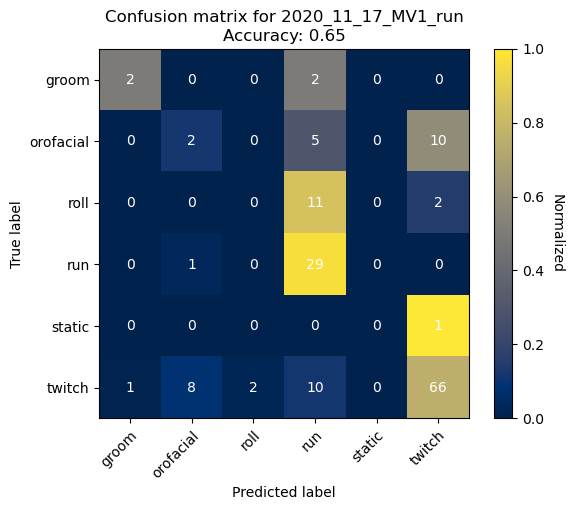

In [ ]:
from sklearn.neighbors import NearestNeighbors

pred_labels_total = []
valid_labels_total = []

for index in range(len(neural_data_paths)):
    embeddings = []
    name = []
    valid_embeddings = []
    valid_name = []
    labels = []
    valid_labels = []
    dataset_name  = neural_data_paths[index].split("/")[-1].split(".")[0]
    temp_data, temp_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.0, max = 0.15)
    temp_valid_data, temp_valid_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.15, max = 0.2)
    # data.extend(temp_data)
    # valid_data.extend(temp_valid_data)
    
    # delete every nomove label from the data and name 
    temp_data = [x for i, x in enumerate(temp_data) if temp_name[i].split('_')[0] != 'nomove']
    temp_name = [x for x in temp_name if x.split('_')[0] != 'nomove']
    temp_valid_data = [x for i, x in enumerate(temp_valid_data) if temp_valid_name[i].split('_')[0] != 'nomove']
    temp_valid_name = [x for x in temp_valid_name if x.split('_')[0] != 'nomove']

    # Load the label dict for this dataset using pickle
    with open(label_paths[index], 'rb') as handle:
        label_dict = pickle.load(handle)
    
    # Create a list of labels for each frame
    for label, data in zip(temp_name, temp_data):
        labels.extend(np.tile(label_dict[label], [len(data), 1]))

    for label, data in zip(temp_valid_name, temp_valid_data):
        valid_labels.extend(np.tile(label_dict[label], [len(data), 1]))

    print('Generating embeddings')
    temp_embeddings = flatten_data([model_group[name_to_model_id[dataset_name]](torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_data)])
    temp_valid_embeddings = flatten_data([model_group[name_to_model_id[dataset_name]](torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_valid_data)])
    embeddings.extend(temp_embeddings)
    valid_embeddings.extend(temp_valid_embeddings)
    name.extend(temp_name)
    valid_name.extend(temp_valid_name)

    labels = np.array(labels)
    valid_labels = np.array(valid_labels)
    decoder = cebra.KNNDecoder(n_neighbors=50, metric='cosine')
    print('Fitting decoder')
    decoder.fit(embeddings, labels)
    pred_labels = decoder.predict(valid_embeddings)
    
    clip_valid_labels = reshape_frames(np.argmax(valid_labels, axis=1), temp_valid_data)
    clip_pred_labels = reshape_frames(np.argmax(pred_labels, axis=1), temp_valid_data)
    clip_valid_labels = [np.argmax(np.bincount(x)) for x in (clip_valid_labels)]
    clip_pred_labels = [np.argmax(np.bincount(x)) for x in (clip_pred_labels)]
    print(clip_valid_labels)

    pred_labels_total.extend(clip_pred_labels)
    valid_labels_total.extend(clip_valid_labels)

confusion = confusion_matrix(valid_labels_total, pred_labels_total)
print(confusion)
plot_confusion_matrix(confusion, ['groom', 'orofacial', 'roll', 'run', 'static', 'twitch'], f'Confusion matrix for {neural_data_paths[0].split("/")[-1].split(".")[0]}')


Generating embeddings
Running t-sne
Plotting
Generating embeddings
Running t-sne
Plotting
Generating embeddings
Running t-sne
Plotting
Generating embeddings
Running t-sne
Plotting
Generating embeddings
Running t-sne
Plotting
Generating embeddings
Running t-sne
Plotting
Generating embeddings
Running t-sne
Plotting
Generating embeddings
Running t-sne
Plotting


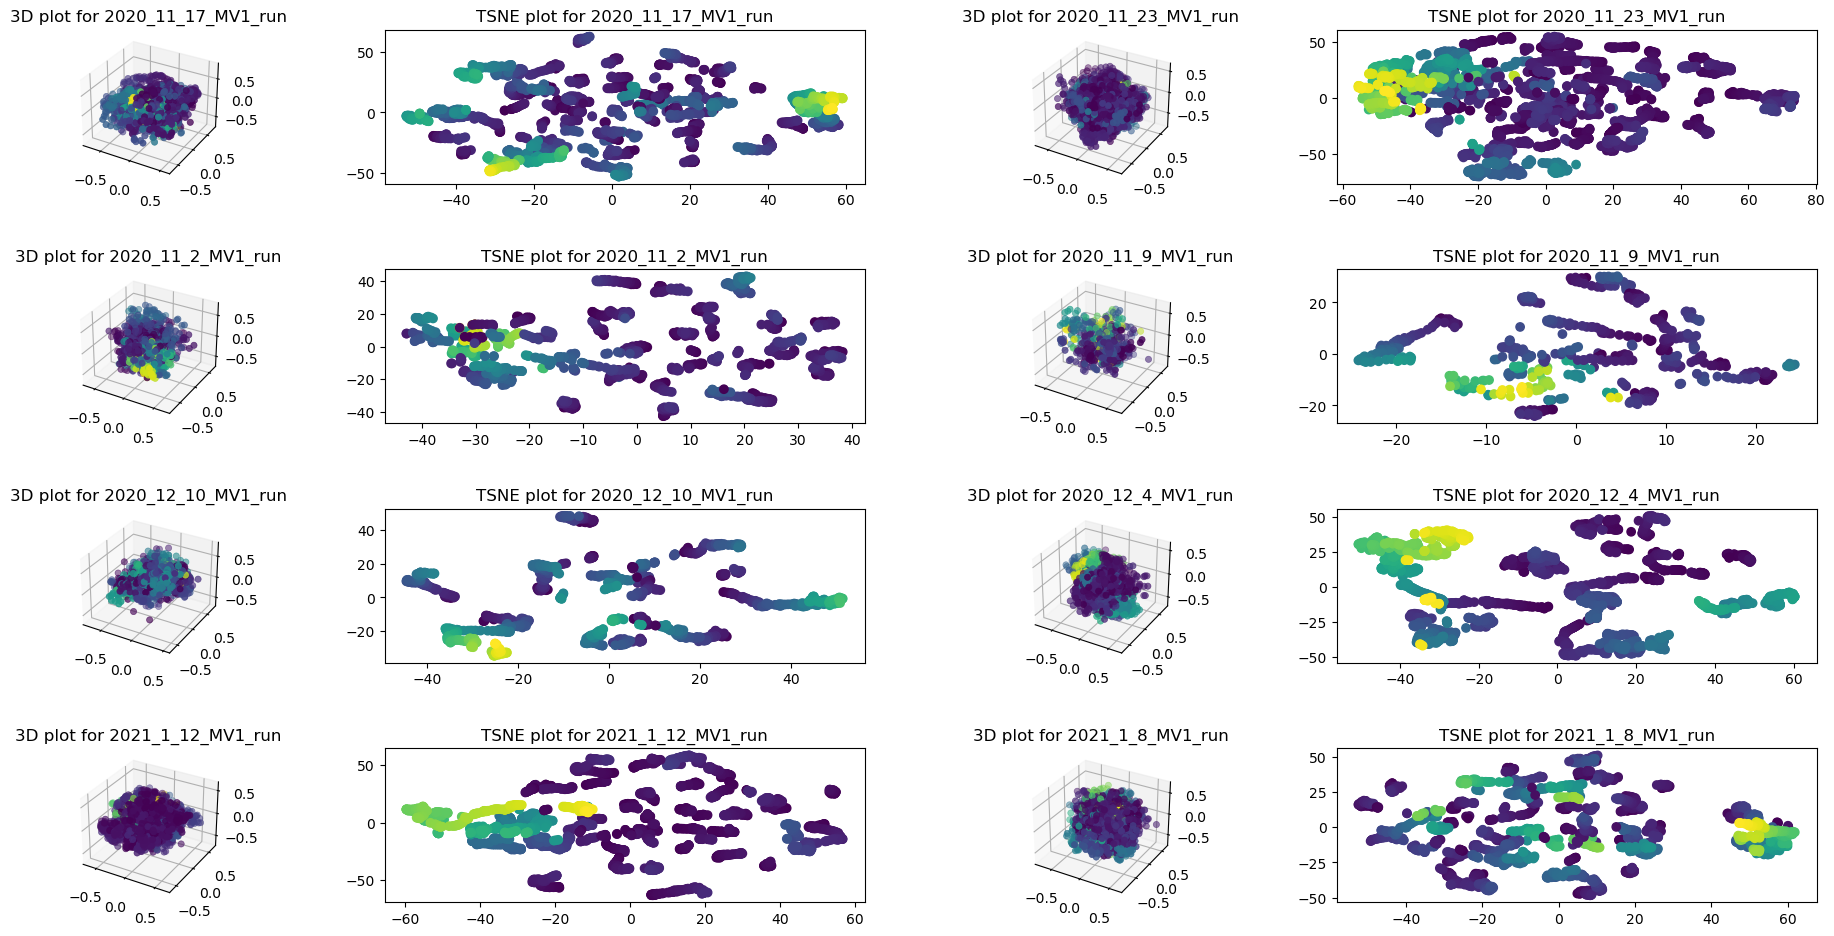

In [ ]:
# import sklearn tsne 
from sklearn.manifold import TSNE
# create a 2 subplots for each session: 
# 1. a 3d plot of the embeddings
# 2. a 2d plot of the embeddings using tsne
# create  8 subplots with 3d projection
fig = plt.figure(figsize=(20, 10))
for index in range(len(neural_data_paths)):
    labels = []
    dataset_name  = neural_data_paths[index].split("/")[-1].split(".")[0]
    temp_data, temp_name = import_data(neural_data_paths[index], lambda x: process_brain(x), min = 0.0, max = 0.02)
    print('Generating embeddings')
    temp_embeddings = flatten_data([model_group[name_to_model_id[dataset_name]](torch.from_numpy(x).float().to('cuda')).to('cpu').detach().numpy() for i, x in enumerate(temp_data)])
    j = 0
    for label, data in zip(temp_name, temp_data):
        j += 1
        if label.split('_')[0] == 'move':
            labels.extend(np.arange(len(data)))
        else:
            labels.extend(np.arange(len(data)))

    # run 3d t-sne on the embeddings
    print('Running t-sne')
    tsne_embeddings = TSNE(n_components=2, metric = 'cosine').fit_transform(temp_embeddings)
    # plot 2 plots, a tsne plot and a 3d subsection of the embeddings
    print('Plotting')
    ax = fig.add_subplot(4, 4, index * 2 + 1, projection='3d')
    ax2 = fig.add_subplot(4, 4, index * 2 + 2)
    ax.scatter(temp_embeddings[:, 0], temp_embeddings[:, 1], temp_embeddings[:, 2], c=labels, cmap='viridis', linewidth=0.5)
    ax.set_title(f'3D plot for {neural_data_paths[index].split("/")[-1].split(".")[0]}')
    ax2.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels)
    ax2.set_title(f'TSNE plot for {neural_data_paths[index].split("/")[-1].split(".")[0]}')
# pad out the fig to prevent text overlap
fig.tight_layout(pad=3.0)
plt.show()